### **Latent Dirichlet Allocation on FOMC Meeting Minutes**

In [ ]:
#import required libraries - for parsing minutes html pages, preprocessing text, lda modeling, and plotting results
import requests #redundant
import re
from bs4 import BeautifulSoup #redundant
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
!pip install -U spacy
!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg") #replace model
nlp.max_length = 3000000

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-09 18:56:43.702208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
# Define URLs for the specific FOMC minutes
URLPath = r'https://www.federalreserve.gov/monetarypolicy/fomcminutes'
URLExt = r'.htm'

# List for FOMC minutes from 2007 onward
MinutesList = [
           '20030204', '20030318', '20030506', '20030625', '20030812', '20030916', '20031028', '20031209', #2003 FOMC minutes
           '20040128', '20040316', '20040504', '20040630', '20040810', '20040921', '20041110', '20041214', #2004 FOMC minutes
           '20050202', '20050322', '20050503', '20050630', '20050809', '20050920', '20051101', '20051213', #2005 FOMC minutes
           '20060131', '20060328', '20060510', '20060629', '20060808', '20060920', '20061025', '20061212', #2006 FOMC minutes
           '20070131', '20070321', '20070509', '20070628', '20070807', '20070918', '20070918','20071031', '20071211', # 2007 FOMC minutes
           '20080130', '20080318', '20080430', '20080625', '20080805', '20080916', '20081029', '20081216', # 2008 FOMC minutes     
           '20090128', '20090318', '20090429', '20090624', '20090812', '20090923', '20091104', '20091216', # 2009 FOMC minutes 
           '20100127', '20100316', '20100428', '20100623', '20100810', '20100921', '20101103', '20101214', # 2010 FOMC minutes 
           '20110126', '20110315', '20110427', '20110622', '20110809', '20110921', '20111102', '20111213', # 2011 FOMC minutes 
           '20120125', '20120313', '20120425', '20120620', '20120801', '20120913', '20121024', '20121212', # 2012 FOMC minutes 
           '20130130', '20133020', '20130501', '20130619', '20130731', '20130918', '20131030', '20131218', # 2013 FOMC minutes 
           '20140129', '20140319', '20140430', '20140618', '20140730', '20140917', '20141029', '20141217', # 2014 FOMC minutes                   
           '20150128', '20150318', '20150429', '20150617', '20150729', '20150917', '20151028', '20151216', # 2015 FOMC minutes    
           '20160127', '20160316', '20160427', '20160615', '20160727', '20160921', '20161102', '20161214', # 2016 FOMC minutes
           '20172001', '20170315', '20170503', '20170614', '20170726', '20170920', '20171101', '20171213', # 2017 FOMC minutes
           '20180131', '20180321', '20180502', '20180613', '20180801', '20180926', '20181108', '20181219', # 2018 FOMC minutes
           '20190130', '20190320', '20190501', '20190619', '20190731', '20190918', '20191030', '20191211', # 2019 FOMC minutes
           '20200129', '20200315', '20200429', '20200610', '20200729'] # 2020 FOMC minutes

In [ ]:
FOMCMinutes = [] # A list of lists to form the corpus
FOMCWordCloud = [] # Single list version of the corpus for WordCloud
FOMCTopix = [] # List to store minutes ID (date) and weight of each para

# Define function to prepare corpus
def PrepareCorpus(urlpath, urlext, minslist, minparalength):

    fomcmins = []
    fomcwordcloud = []
    fomctopix = []
    
    for minutes in minslist:
        
        response = requests.get(urlpath + minutes + urlext) # Get the URL response
        soup = BeautifulSoup(response.content, 'lxml') # Parse the response
        
        # Extract minutes content and convert to string
        minsTxt = str(soup.find("div", {"id": "content"})) # Contained within the 'div' tag
                    
        # Clean text - stage 1
        minsTxt = minsTxt.strip()  # Remove white space at the beginning and end
        minsTxt = minsTxt.replace('\r', '') # Replace the \r with null
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space. 
        minsTxt = minsTxt.replace(' ', ' ') # Replace " " with space.
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') # Remove extra spaces

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)    
        minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                         '([_]+)|' # Remove series of underscores
                         '(http[^\s]+)|' # Remove website addresses
                         '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                         '', minsTxt) # Replace with null

        # Find length of minutes document for calculating paragraph weights
        minsTxtParas = minsTxt.split('\n') # List of paras in minsTxt, where minsTxt is split based on new line characters
        cum_paras = 0 # Set up variable for cumulative word-count in all paras for a given minutes transcript
        for para in minsTxtParas:
            if len(para)>minparalength: # Only including paragraphs larger than 'minparalength'
                cum_paras += len(para)
        
        # Extract paragraphs
        for para in minsTxtParas:
            if len(para)>minparalength: # Only extract paragraphs larger than 'minparalength'
                
                topixTmp = [] # Temporary list to store minutes date & para weight tuple
                topixTmp.append(minutes) # First element of tuple (minutes date)
                topixTmp.append(len(para)/cum_paras) # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text
                            
                # Parse cleaned para with SpaCy
                minsPara = nlp(para)
                
                minsTmp = [] # Temporary list to store individual tokens
                
                # Further cleaning and selection of text characteristics
                for token in minsPara:
                    if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB"): # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                        minsTmp.append(token.lemma_.lower()) # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                        fomcwordcloud.append(token.lemma_.lower()) # Add word to WordCloud list
                fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
                fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing
            
    return fomcmins, fomcwordcloud, fomctopix

In [ ]:
FMinute, FWordCloud, FTopix = PrepareCorpus(urlpath=URLPath, urlext=URLExt, minslist=MinutesList, minparalength=200)

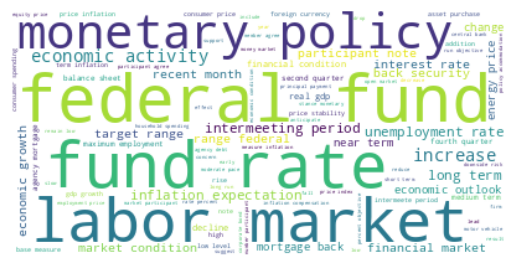

In [ ]:
# Generate and plot WordCloud for full corpus
wordcloudX = WordCloud(background_color="white").generate(','.join(FWordCloud)) # NB. 'join' method used to convert the documents list to text format
plt.imshow(wordcloudX, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Form dictionary by mapping word IDs to words
ID2word2 = corpora.Dictionary(FMinute)

# Set up Bag of Words and TFIDF
corpus2 = [ID2word2.doc2bow(doc) for doc in FMinute] # Apply Bag of Words to all documents in corpus
TFIDF2 = models.TfidfModel(corpus2) # Fit TF-IDF model
trans_TFIDF2 = TFIDF2[corpus2] # Apply TF-IDF model

In [ ]:
SEED2 = 130 # Set random seed
NUM_topics2 = 8 # Set number of topics
ALPHA2 = 0.15 # Set alpha
ETA2 = 1.25 # Set eta

# Train LDA model using the corpus
lda_model2 = gensim.models.LdaMulticore(corpus=trans_TFIDF2, num_topics=NUM_topics2, id2word=ID2word2, random_state=SEED2, alpha=ALPHA2, eta=ETA2, passes=100)

In [ ]:
# Set up coherence model
coherence_model_lda2 = gensim.models.CoherenceModel(model=lda_model2, texts=FMinute, dictionary=ID2word2, coherence='c_v')

# Calculate coherence
coherence_lda2 = coherence_model_lda2.get_coherence()
print(coherence_lda2)

0.47860562385715527


In [ ]:
para_num = 0 # Set document counter
for para in FTopix:
    TFIDF_para2 = TFIDF2[corpus2[para_num]] # Apply TFIDF model to individual minutes documents
    # Generate and store weighted topic proportions for each para
    for topic_weight in lda_model2.get_document_topics(TFIDF_para2): # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
        FTopix[para_num].append(FTopix[para_num][1]*topic_weight[1]) # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
    para_num += 1

In [ ]:
# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF2 = pd.DataFrame(FTopix, columns=['Date', 'Weight', 'Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'])

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF2 = pd.pivot_table(FOMCTopixDF2, values=['Inflation', 'Topic 2', 'Consumption', 'Topic 4', 'Market', 'Topic 6', 'Topic 7', 'Policy'], index='Date', aggfunc=np.sum)

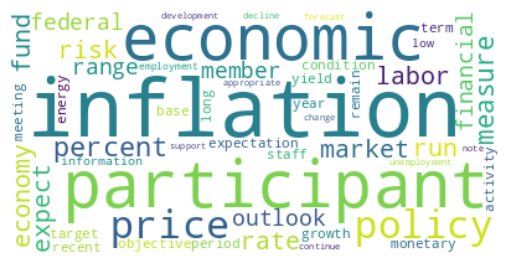

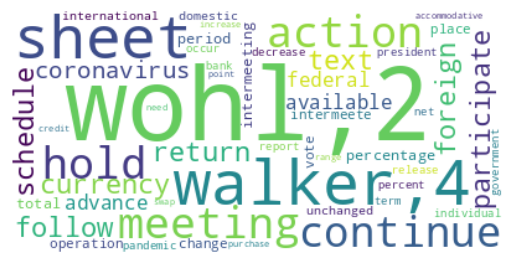

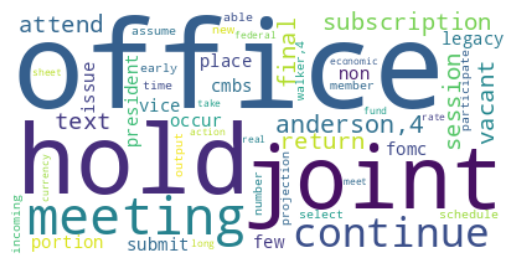

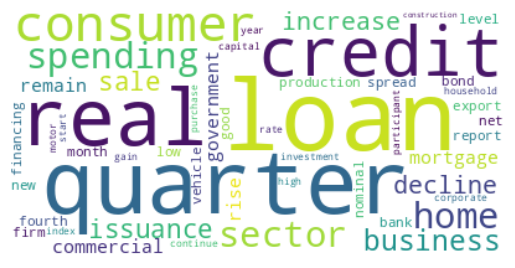

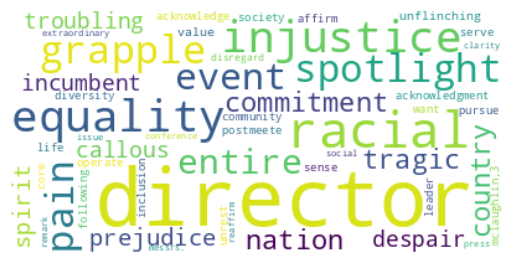

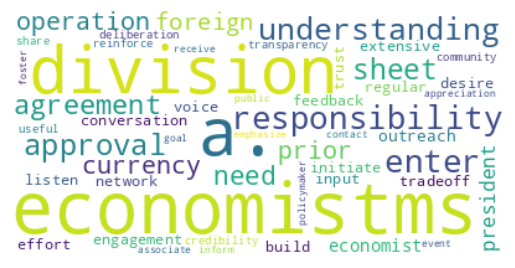

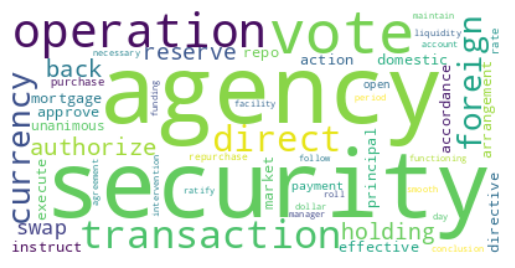

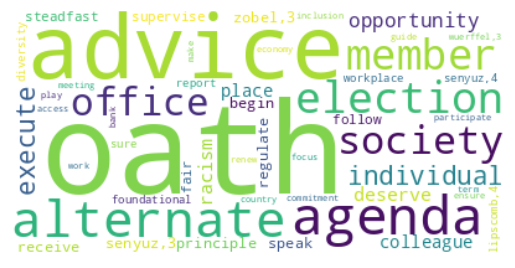

In [ ]:
topic2 = 0 # Initialize counter
while topic2 < NUM_topics2:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq2 = dict(lda_model2.show_topic(topic2, topn=50)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic2 += 1
    
    # Generate Word Cloud for topic using frequencies
    wordcloud2 = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq2) 
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<Axes: xlabel='Date'>

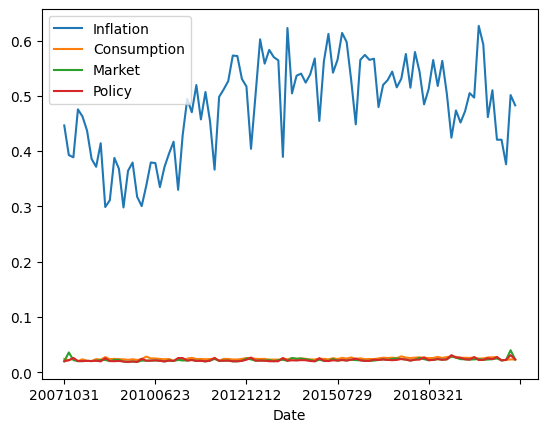

In [ ]:
# Plot results - select which topics to print
TopixAggDF2.plot(y=['Inflation', 'Consumption', 'Market', 'Policy'], kind='line', use_index=True)

In [ ]:
!pip install notebookjs
from notebookjs import execute_js

In [ ]:
#loading JS and CSS files for D3 visualization
code_js  = open("/content/drive/MyDrive/Colab Notebooks/HW2 vizualisation/vis02.js", "r").read()
code_css = open("/content/drive/MyDrive/Colab Notebooks/HW2 vizualisation/vis01.css", "r").read()

In [ ]:
import random
import datetime
from json import dumps #import dumps for json serializable date formats

In [ ]:
FOMCTopixDF3=FOMCTopixDF2.filter(items=['Date','Inflation','Consumption','Market','Policy'])
#changing the yyyymmdd format to yyyy-mm-dd to suit visualization template
FOMCTopixDF3['Date'] = pd.to_datetime(FOMCTopixDF3['Date'], format='%Y%m%d')
FOMCTopixDF3['Date'] = FOMCTopixDF3['Date'].dt.strftime('%Y-%m-%d')

# convert DataFrame to list of dictionaries
dict_list = FOMCTopixDF3.to_dict('records')

# modify dictionary keys to match desired format
for d in dict_list:
    d['date'] = d.pop('Date')
    d['Inflation'] = d.pop('Inflation')
    d['Consumption'] = d.pop('Consumption')
    d['Market'] = d.pop('Market')
    d['Policy'] = d.pop('Policy')

print(dict_list)

[{'date': '2007-10-31', 'Inflation': 0.00036301231376378884, 'Consumption': 0.004660799350814351, 'Market': 0.000362210027777478, 'Policy': 0.0003622825338372034}, {'date': '2007-10-31', 'Inflation': 0.00041935423925589, 'Consumption': 0.00041885973019293167, 'Market': 0.0004188654271809685, 'Policy': 0.00041886463957893573}, {'date': '2007-10-31', 'Inflation': 0.00022782384541476726, 'Consumption': 0.0002279423115311179, 'Market': 0.0002277777956029246, 'Policy': 0.0002277491632397958}, {'date': '2007-10-31', 'Inflation': 0.00038931307823467565, 'Consumption': 0.0003879639667203815, 'Market': 0.00038772169719367714, 'Policy': 0.00038775198088451514}, {'date': '2007-10-31', 'Inflation': 0.0005096625720117447, 'Consumption': 0.0005035666744842355, 'Market': 0.0005032424690463739, 'Policy': 0.0005032310466291158}, {'date': '2007-10-31', 'Inflation': 0.00042686325908218814, 'Consumption': 0.0004258179368352282, 'Market': 0.0004258171660622987, 'Policy': 0.0004258125799633683}, {'date': '2

In [ ]:
#specifying path and drawing D3 plot from code_js
d3_path = "https://d3js.org/d3.v7.min.js"

execute_js(library_list=[d3_path, code_js], 
           main_function="draw_stacked_plot", 
           css_list=[code_css],
           data_dict=dict_list)

In [ ]:
#generate 241 random dates 
start_dt = datetime.date(1993, 2, 3) 
end_dt = datetime.date(2017, 3, 1)
time_between_dates = end_dt - start_dt
days_between_dates = time_between_dates.days
random_dates = [start_dt + datetime.timedelta(days=random.randrange(days_between_dates)) for i in range(0,241)]
random_dates.sort()
random_dates=[dumps(random_dates[i], default=str) for i in range(0,241)]
random_dates=[i.replace('"', '') for i in random_dates]
random_dates[0]

'1993-07-12'

In [ ]:
n1=[random.randint(0,300) for i in range(0,241)] #frequency of topic 1 for each date
n2=[random.randint(0,300) for i in range(0,241)]
n3=[random.randint(0,300) for i in range(0,241)]
n4=[random.randint(0,300) for i in range(0,241)]
n5=[random.randint(0,300) for i in range(0,241)]
n6=[random.randint(0,300) for i in range(0,241)]
data1=[]
for i in range(0,len(random_dates)):
  data1.append({'date': random_dates[i].replace('"', ''), 'Inflation': n1[i]/1000, 'Consumption':n2[i]/1000,'Market':n3[i]/1000, 'Policy':n4[i]/1000 })
data1[0]

{'date': '1993-07-12',
 'Inflation': 0.286,
 'Consumption': 0.092,
 'Market': 0.232,
 'Policy': 0.256}

In [ ]:
#generating visualization with randomly generated data
d3_path = "https://d3js.org/d3.v7.min.js"

execute_js(library_list=[d3_path, code_js], 
           main_function="draw_stacked_plot", 
           css_list=[code_css],
           data_dict=data1)